In [ ]:
Instructions
1. Change Subject Code in first cell, Select this cell and run "Run all below selected cell"
2. Allow program to fully run then SAVE THE FILE
3. # Run these commands to get HTML File of Report 
export SUBJECT = subject code
jupyter nbconvert --to html --no-input Courier_Report_v2.ipynb --output $SUBJECT\_courier_report.html


In [2]:
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.append('/home1/jrudoler/src/')
import cmlreaders as cml
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['savefig.facecolor']='white'
from matplotlib.collections import LineCollection
from adjustText import adjust_text
import seaborn as sns
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None
import pandas_to_pybeh as pp
import scipy as scp
from scipy.spatial import distance
from polar import circular_hist
import os
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas
from reportlab.lib.utils import ImageReader
import matplotlib.image as mpimg
from IPython.display import display, Markdown
import time

In [3]:
sub = 'R1573T'
exp = 'DBOY1'
data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] ==exp]

data = data[data['subject']==sub]

full_evs = None
for i, row in data.iterrows():
    read = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'])
    evs = read.load('task_events')
    full_evs = evs if full_evs is None else full_evs.append(evs)
# only real delivery days
full_evs = full_evs.reset_index().drop(columns='index')


In [4]:
display(
    Markdown(
        '# '+sub + ' Courier Report'
    )
)

# R1573T Courier Report

In [5]:
sess = full_evs.loc[full_evs['trial'] != -999]
sess = sess.loc[sess['type'] == 'WORD']
sessions = sess.groupby('session')['trial'].unique()
sess_codes = []
for sess in sessions.index:
    sess_codes.append(sub+':'+exp+':'+str(sess))

ddays = []
for sess in sessions:
    ddays.append(len(sess))

timestamp = full_evs.groupby('session').mstime.first()/1000
dates = []
for sec in timestamp:
    dates.append(time.strftime('%Y-%m-%d', time.localtime(sec)))

minutes = round((full_evs.groupby('session').mstime.last() - full_evs.groupby('session').mstime.first())/1000/60, 2)
    
sessions = pd.DataFrame()
sessions['Session Code'] = pd.Series(sess_codes)
sessions['Date'] = pd.Series(dates)
sessions['Length [min]'] =  minutes
sessions['Delivery Days'] = pd.Series(ddays)
sessions = sessions.style.hide_index()
sessions

Session Code,Date,Length [min],Delivery Days
R1573T:DBOY1:0,2021-07-28,32.7,2


In [6]:
pres = full_evs[full_evs.type=='WORD']
cuerec = full_evs[full_evs.type=='CUED_REC_WORD']
cue = full_evs[full_evs.type=='CUED_REC_CUE']
final = full_evs[full_evs.type=='FFR_REC_WORD']
storerec = full_evs[full_evs.type=='SR_REC_WORD']

recalls = [full_evs.loc[i, "item"]==full_evs.loc[i+1, "item"] for i in cue.index.values]
immediate_recalls = pres['recalled']
srRate = sum([len(storerec[(storerec.intrusion==0)&(storerec.session==i)].item.unique()) for i in storerec.session.unique()])/sum([len(pres[pres.session==i].store.unique()) for i in pres.session.unique()])
ffr = np.hstack([np.isin(pres[pres.session==i].item, final[final.session==i].item.unique()) for i in full_evs.session.unique()])

rates_df = pd.DataFrame({'Recall': ["Cued Recall", "Immediate FR", "Store FR", "Final FR"], "Rate (%)": [np.mean(recalls), np.mean(immediate_recalls), srRate, np.mean(ffr)]})
rates_df.iloc[:, 1] = np.round(rates_df.iloc[:, 1]*100, 2)
rates_html = rates_df.to_html()

display(
    Markdown(
        '#### Recall Rates'
    )
)
rates_df

#### Recall Rates

,Recall,Rate (%)
0,Cued Recall,8.33
1,Immediate FR,20.83
2,Store FR,0.00
3,Final FR,0.00


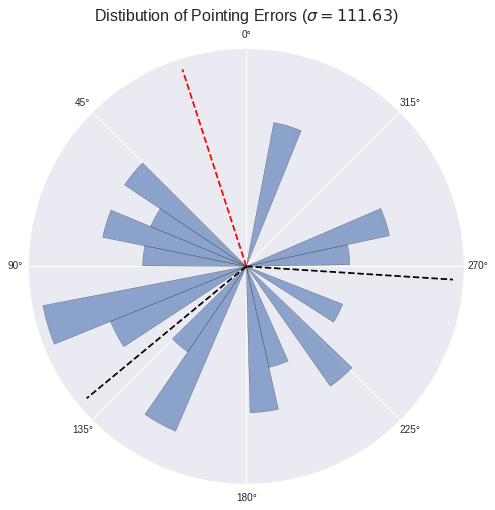

In [7]:
pointing_tasks = full_evs[full_evs.type == 'pointing finished']
err_angles = np.radians((pointing_tasks.correctPointingDirection - pointing_tasks.submittedPointingDirection)).values
err_angles = (err_angles+np.pi) % (2*np.pi) - np.pi

# correct for distribution of available stores
# loc_evs = full_evs[(full_evs.storeX!=-999)&(full_evs.store!='-999')]
# stores = loc_evs.groupby('store').agg('mean')[['storeX', 'storeZ']]
# xstores = stores['storeX'].values; zstores = stores['storeX'].values
# angular_range = []
# for i, row in pointing_tasks.iterrows():
#     # current player location
#     xloc, zloc = row[['presX', 'presZ']]
#     # distribution of angles from location to all stores
#     angles = np.arctan((zloc-zstores)/(xloc-xstores))
#     angles[xloc-xstores<0]+= np.pi
#     angular_range.append(np.ptp(angles))
# angular_range = np.array(angular_range)
# # multiply errors by ratio of whole field to available angular distribution of stores
# err_angles = err_angles * (2*np.pi)/ angular_range

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
n, bins, _ = circular_hist(ax, err_angles, offset=np.pi/2, bins=30, ec='k', alpha=0.6)
ax.vlines([np.mean(err_angles)+err_angles.std(), np.mean(err_angles)-err_angles.std()], ymin=0, ymax=np.max(n/err_angles.size/np.pi)**.5,
         ls='--')
ax.vlines(np.mean(err_angles),
          ymin=0, ymax=np.max(n/err_angles.size/np.pi)**.5,
         ls='--', colors='r')

ax.set_title(r'Distibution of Pointing Errors ($\sigma = {:.2f}$)'.format(err_angles.std()*180/np.pi), fontsize=16)
plt.show()


Median Delivery Time: 40.47 seconds
RMSE: 38.165, R^2: 0.032


#### Travel Time

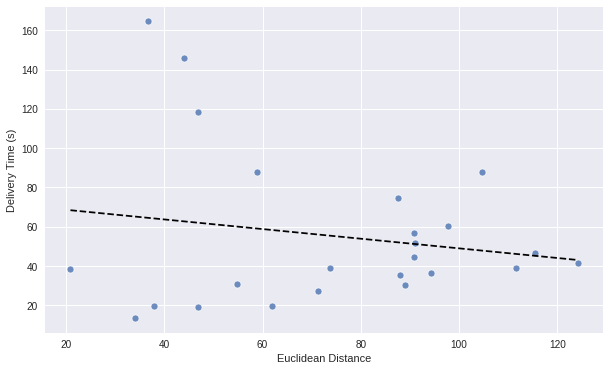

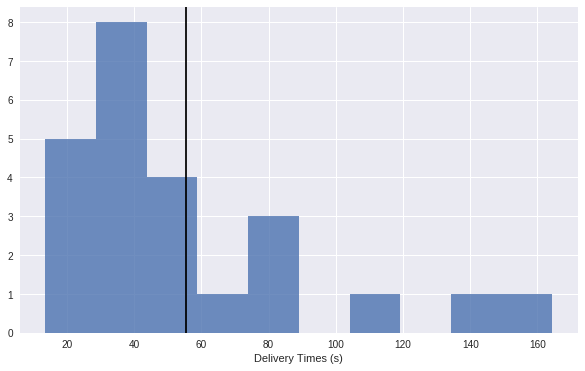

In [8]:
deliveries = full_evs[full_evs.type=='WORD']
diff_times = np.insert(np.diff(full_evs.mstime), 0, 0)
delivery_times = diff_times[full_evs.type == 'WORD']
print('Median Delivery Time: {:.2f} seconds'.format(np.median(delivery_times)/1000))

distX = np.insert(np.diff(deliveries.storeX), 0, deliveries.iloc[0].storeX)
distZ = np.insert(np.diff(deliveries.storeZ), 0, deliveries.iloc[0].storeZ)
dist = np.sqrt(distX**2 + distZ**2)

plt.figure(figsize=(10, 6))
p, resid, _, _, _= np.polyfit(dist, delivery_times/1000, 1, full=True)
sns.scatterplot(dist, delivery_times/1000, alpha=.8)
plt.xlabel('Euclidean Distance')
plt.ylabel('Delivery Time (s)')
vals = np.arange(np.min(dist), np.max(dist))
plt.plot(vals, np.polyval(p, vals), 'k--')
rmse = np.sqrt(np.mean((np.polyval(p, dist) - delivery_times/1000)**2))
r2 = np.corrcoef(dist, delivery_times/1000)[0, 1]**2
print(r'RMSE: {:.3f}, R^2: {:.3f}'.format(rmse, r2))

plt.figure(figsize=(10, 6))
plt.xlabel('Delivery Times (s)')
plt.hist(delivery_times/1000, alpha=.8)
_ = plt.axvline(delivery_times.mean()/1000, 0, max(delivery_times/1000), c='k')
display(
    Markdown(
        '#### Travel Time'
    )
)

#### Serial Position Curve

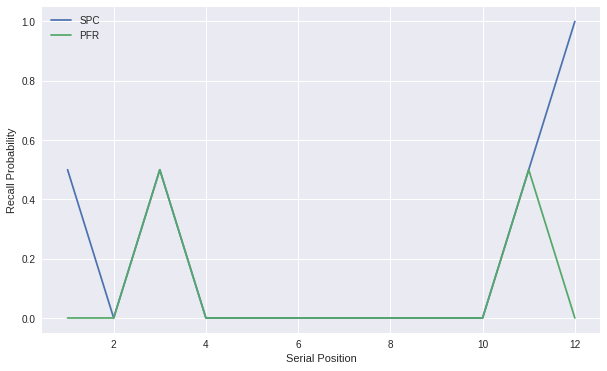

In [9]:
deliveries = full_evs[full_evs.type=='WORD']
deliveries['pos'] = deliveries.groupby(['subject', 'session', 'trial']).cumcount()
delivRecalls = deliveries.pivot_table(values = ['recalled'], index=['subject', 'session', 'trial'], columns='pos')

recword = full_evs[full_evs.type=='REC_WORD']
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
recallpos = recword.pivot_table(values = ['serialpos'], index=['subject', 'session', 'trial'], columns='pos')

plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 13), delivRecalls['recalled'].mean(), label = 'SPC')
plt.xlabel('Serial Position')
plt.ylabel('Recall Probability')
listLength = 12
pfr = np.zeros(listLength)
for pos in recallpos['serialpos'].iloc[:, 0]:
    if pos>0:
        pfr[int(pos)-1]+=1
    else:
        continue
pfr = pfr/len(recallpos)

plt.plot(np.arange(1, listLength + 1), pfr, label = 'PFR')
plt.legend()
display(
    Markdown(
        '#### Serial Position Curve'
    )
)
plt.show()


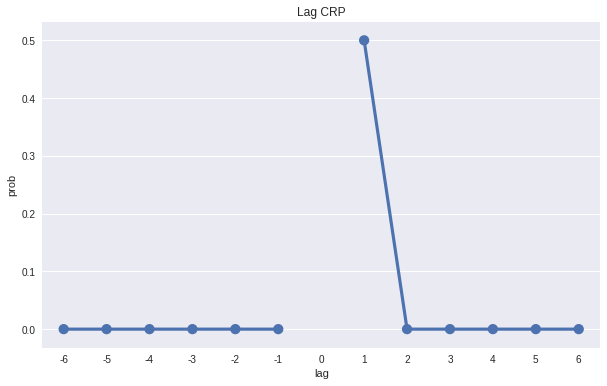

In [10]:
import pandas_to_pybeh as pb

# filter out lists with no recalls
for i in full_evs.session.unique():
    for j in full_evs.trial.unique():
        word = full_evs[(full_evs.session==i)&(full_evs.trial==j)&(full_evs.type=='REC_WORD')]
        if (len(word)==0)&(j>0):
            full_evs.drop(full_evs[(full_evs.session==i)&(full_evs.trial==j)].index, inplace=True)

full_evs['itemno'] = full_evs['item'].astype('category').cat.codes
crp_df = full_evs.groupby(['subject']).apply(pb.pd_crp, itemno_column='itemno', 
                               list_index=['subject', 'session', 'trial'], 
                               lag_num=6).reset_index()

plt.figure(figsize=(10, 6))
crp = sns.pointplot(data=crp_df, x='lag', y='prob')
_ = crp.set_title('Lag CRP')


#### Path Traveled

Session 0


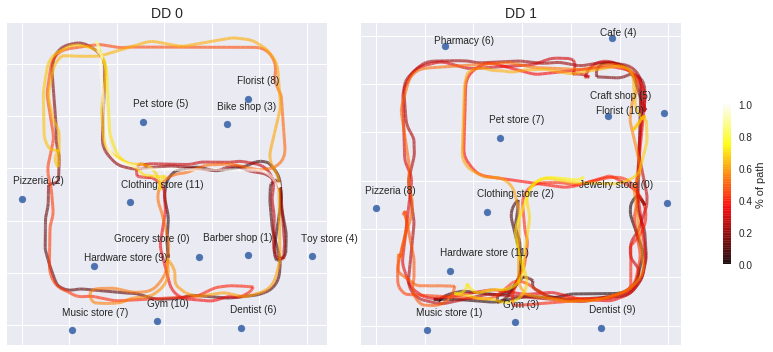

In [11]:
display(
    Markdown(
        '#### Path Traveled'
    )
)
# Only define if it is an underscore like R1575E_1
# sub = 'R1575E_1'
for session in data['session'].unique():
    print('Session %d' %session)
    log = pd.read_json('/data/eeg/{}/behavioral/DBOY1/session_{}/session.jsonl'.format(sub, session), lines=True)
    log = log[(log.type=='PlayerTransform')|(log.type=='object presentation begins')]

    def extract_position(row):
        if row.type=='PlayerTransform':
            return (row['data']['positionX'], row['data']['positionY'], row['data']['positionZ'])
        elif row.type=='object presentation begins':
            return eval(row['data']['player position'])
        else:
            return np.nan

    log['location']=log.apply(extract_position, axis=1)
    log['trial']=log.apply(lambda row: row['data']['trial number'] if np.isin('trial number', list(row['data'].keys())) else np.nan, axis=1)
    movements = log.fillna(method='pad').dropna()
    sess_pos = np.stack(list(map(list, movements.location.values)))
    
    group_mov = movements.groupby('trial')
    dd_list = np.array(list(group_mov.groups.keys())).astype(int)
    pos_by_list = [np.stack(list(map(list, group_mov.get_group(i)['location']))) for i in dd_list]
    fig, ax = plt.subplots(len(dd_list)//2+len(dd_list)%2, 2, figsize=(12, 5*(len(dd_list)//2+len(dd_list)%2)))
    ax = ax.ravel()
    for i, dd in enumerate(dd_list):
        store_locs = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: eval(json['store position']))
        store_names = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: json['store name'])
        list_stores = np.stack(list(map(list, store_locs.values)))

        points = np.array([pos_by_list[i][:, 0], pos_by_list[i][:, 2]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='hot')
        # Set the values used for colormapping
        lc.set_array(np.linspace(0, 1, len(segments)))
        lc.set_linewidth(3); lc.set_alpha(.6)
        line = ax[i].add_collection(lc)
        ax[i].scatter(list_stores[:, 0], list_stores[:, 2])
        texts = []
        for x, y, name, order in zip(list_stores[:, 0], list_stores[:, 2], store_names, np.arange(len(store_names))):
            texts.append(ax[i].text(x-5, y+5, name.capitalize() + ' ({})'.format(order)))
        adjust_text(texts)
        ax[i].set_title('DD %d' %dd, fontsize=14)
        ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
    plt.tight_layout()
    cbar = fig.colorbar(line, ax=ax[:], location='right', shrink = 0.5)
    cbar.set_label('% of path')
    fig.set_facecolor('white')
    plt.show()

#### EEG Data Check

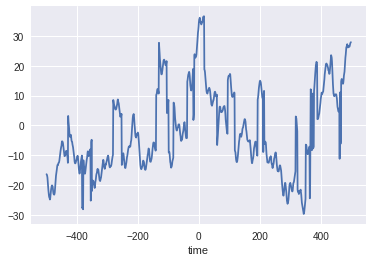

In [12]:
# Test EEG (assumes bipolar)
pairs = read.load('pairs')
pres = evs[evs.type=='WORD']
eeg = read.load_eeg(pres, scheme=pairs, rel_start=-500, rel_stop=500).to_ptsa()
plt.plot(eeg.time, eeg.values[pres.recalled.astype(bool)].mean((0, 1))-eeg.values[~pres.recalled.astype(bool)].mean((0, 1)))
plt.xlabel('time')
directory = sub
display(
    Markdown(
        '#### EEG Data Check'
    )
)